# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
# If you plan on using Google Colab then uncomment and modify the following lines of code

# from google.colab import drive
# drive.mount('/content/drive')

**Installing surprise library**

In [2]:
# Uncomment the following line of code to install the surprise library

# !pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

%matplotlib inline

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
data = pd.read_csv("data/ratings_data.csv", names=["user_id", "prod_id", "rating", "timestamp"])
df = data.drop("timestamp", axis=1)
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [5]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [6]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [7]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [8]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [9]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [10]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Write your observations here:** There are 65290 rows and 3 columns in the final dataset.

### **Data types**

In [11]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Write your observations here:** Both the user_id and prod_id columns are of type object, while the rating column is of type float.

### **Checking for missing values**

In [12]:
# Check for missing values present and provide observations
df_final.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Write your observations here:** There are no missing values in our data.

### **Summary Statistics**

In [13]:
# Summary statistics of 'rating' variable and provide observations
df_final["rating"].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Write your observations here:** The 'rating' feature has a total count of 65290 observations with a mean of ~4.29 and standard deviation of ~0.99. Ratings range from a minimum of 1 to a maximum of 5 with the 50th percentile being 5 and the 25-percentile being 4. This indicates that most users rate products very highly. However, a graphical representation of the ratings will better indicate this distribution and the magnitude of its skewness.

### **Checking the rating distribution**

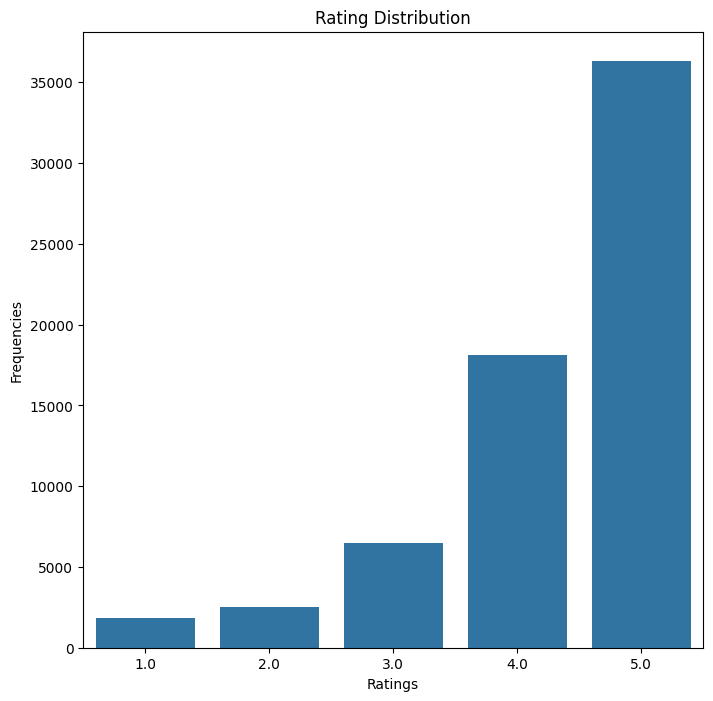

In [14]:
# Create the bar plot and provide observations
plt.figure(figsize=(8, 8))
sns.countplot(df_final, x="rating")
plt.title("Rating Distribution")
plt.xlabel("Ratings")
plt.ylabel("Frequencies")
plt.show()

**Write your observations here:** The above plot confirms the large left skewness in the distribution that was observed from the summary statistics. Most users rate products as 5 or 4 with very few of them rating products otherwise (3, 2, 1). Interestingly, the above plot seems to exhibit the shape of an exponential distribution, which one would not expect given the typical experience of how users interact and rate products. However, it is unknown if this is due to the quality of the products presented to users or if the users in the data had a lower satisfication threshold.

### **Checking the number of unique users and items in the dataset**

In [15]:
# Number of total rows in the data and number of unique user id and product id in the data
print(f"Number of total rows in the data: {len(df_final)}")
print(f"Number of unique users: {df_final['user_id'].nunique()}")
print(f"Number of unique products: {df_final['prod_id'].nunique()}")

Number of total rows in the data: 65290
Number of unique users: 1540
Number of unique products: 5689


**Write your observations here:** There are 1540 unique users and 5689 unique products and so there are 1540 x 5689 = 8,761,060 total possible user-product interactions (ratings). However, we only have 65290 total ratings, i.e. ~0.745%, of these possible interactions. Therefore, we are in a situation where a recommender system can be used to recommend new products to users.

### **Users with the most number of ratings**

In [16]:
# Top 10 users based on the number of ratings
top_ten_users = df_final["user_id"].value_counts().head(10)
top_ten_users

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

In [17]:
# A quick check to see the maximum number times a user rated a product
print(f"Maximum times a user rated a product: {df_final.groupby(['user_id', 'prod_id'])['rating'].count().max()}")

Maximum times a user rated a product: 1


**Write your observations here:** The user with user_id ADLVFFE4VBT8 has interacted with the most products, namely they have rated 295 products. As there are 5689 unique products available, this user has not yet interacted with 5689 - 295 = 5,394 products. This presents an opportunity for a recommender system to be used to predict this users ratings for these uninteracted with products. We also note that each user rated a product at most once in the dataset.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

**Important Note:** Since randomness exists within each model, the model results produced during the latest run may not match the written description.

## **Model 1: Rank Based Recommendation System**

In [18]:
# Calculate the average rating for each product
# Calculate the count of ratings for each product
# Create a dataframe with calculated average and count of ratings
final_rating = df_final.groupby("prod_id")["rating"].agg(average_rating="mean", rating_count="count")

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by="average_rating", ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head(5)

,average_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [19]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, col_x="average_rating", col_y="rating_count", min_interactions=10):
    """Returns the top n products in a dataframe along col_x
    conditioned if the value of col_y > min_interactions.
    
    Parameters
    ----------
    data : pd.DataFrame
    n : int
    col_x : str = "average_rating"
        The name of the column to compute the top n items on.
    col_y : str = "rating_count"
        The name of the column to check for minimum interactions.
    min_interactions : int = 10

    Returns
    -------
    pd.DataFrame

    """
    
    # Finding products with minimum number of interactions
    threshold_data = data[data[col_y] > min_interactions]
    
    # Sorting values with respect to average rating 
    threshold_data = threshold_data.sort_values(by=col_x, ascending=False)

    return threshold_data.head(n)


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [20]:
top_n_products(final_rating, 5, min_interactions=50)

,average_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [21]:
top_n_products(final_rating, 5, min_interactions=100)

,average_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106
B004CLYEDC,4.669492,118


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [22]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [23]:
def precision_recall_at_k(model, testset, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [24]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
dataset = Dataset.load_from_df(df_final[["user_id", "prod_id", "rating"]], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(dataset, test_size=0.2, random_state=1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [25]:
# Declaring the similarity options
sim_options = {
    "name": "cosine",
    "user_based": True
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user, testset=testset)

RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853


**Write your observations here:** The rmse, precision, recall, and f1 scores metrics are 1.026, 0.844, 0.862, 0.853, respectively. The rmse metric indicates how far the model's predicted ratings are to the actual ratings and a value of 1.026 is relatively high for this dataset. Although the model's rmse score is high, its precision, recall, and f1 scores are relatively good, given it is our first baseline model. Recall, that we can concretely interpret the precision and recall metrics as follows:

- **Precision**: out of the recommended products, 86.2% of them are relevant.
- **Recall**: out of the relevant products, 84.4% of them are recommended.

This baseline model uses default hyperparameters and so we will perform a hyperparameter search later in order to see if we can improve upon this model's results. However, as it stands, this model is already performing well given our metrics. Nevertheless, we need to do a comparative analysis with other models to really determine how good this model.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [26]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict(uid="A3LDPF5FMB782Z", iid="1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here:** The predicted rating for `user=A3LDPF5FMB782Z` on `product=1400501466` is 3.33 which is an exteremely low estimate of the true rating of 5. According to the model, the product does not meet the threshold requirement to be recommended, and hence this user-product pair is a false negative example. Since the recall of the model is high (i.e. false negative rate is low), there should not be many of these user-product pairs. As such, the above prediction only indicates that the model does not perform for this specific examples and should not be used to undermine the general performance of the model on other examples.

It is also interseting to note that from our EDA, we found that there were very few products rated 3 compared to 4 and 5. Perhaps users that are similar to `user=A3LDPF5FMB782Z` disliked this product even though `user=A3LDPF5FMB782Z` liked it. Exploring this example in detail may prove to be interesting in order to see how and why this low rating was predicted.

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [27]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [28]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

['AN9WA4C5E7YY5',
 'A4GHPW9AAH1NY',
 'ANEXFROORI6F6',
 'A1Y4EWMUTW73GD',
 'ASFW4ZMNZJKDA']

* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.** 

In [29]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict(uid="A2UOHALGF2X77Q", iid="1400501466", r_ui=None, verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.34   {'actual_k': 3, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.3355875039423895, details={'actual_k': 3, 'was_impossible': False})

**Write your observations here:** The predicted rating of `user=A2UOHALGF2X77Q` on `product=1400501466` is 4.34. According to our terminology and our threshold value of 3.5, this product would be recommended to the user.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [30]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    "k": [30, 40, 50],
    "min_k": [1, 3, 6, 9],
    "sim_options": {
        "name": ["msd", "cosine", "Pearson"],
        "user_based": [True]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
sim_user_user_gs = GridSearchCV(KNNBasic, param_grid=param_grid, cv=3, n_jobs=-1)

# Fitting the data
sim_user_user_gs.fit(dataset)

# Best RMSE score
best_score = sim_user_user_gs.best_score["rmse"]
print(f"Best score: {best_score}")

# Combination of parameters that gave the best RMSE score
best_params = sim_user_user_gs.best_params["rmse"]
print(f"Best params: {best_params}")

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pe

**Observation:** Based on the rmse metric, the best score was ~0.972 and the best parameters found after performing a grid search were `k=50, min_k=3, sim_options={"name": "cosine", "user_based": True}`.

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [31]:
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_opt = KNNBasic(**best_params, verbose=False, random_state=1)

# Training the algorithm on the trainset
sim_user_user_opt.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_opt, testset=testset)

RMSE: 0.9759
Precision:  0.834
Recall:  0.896
F_1 score:  0.864


**Write your observations here:** The rmse, precision, recall, and f1 score of the tuned model are 0.98, 0.841, 0.886, 0.863, respectively. We can see that after tuning the model's hyperparamters, the rmse, recall, and f1 score metrics improved compared to the baseline model. The tuned model has a slightly lower precision compared to the baseline, however, the tuned model retains a better f1 score since its recall increased more relative to the decrease in precision. We can therefore say that this model's performance has improved after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [32]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_opt.predict(uid="A3LDPF5FMB782Z", iid="1400501466", r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [33]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_user_user_opt.predict(uid="A2UOHALGF2X77Q", iid="1400501466", r_ui=None)

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:** The predicted rating for `user=A3LDPF5FMB782Z` and product `product=1400501466` with the tuned model is ~3.33 which is very far from the ground truth value of 5. On this example, we can see that the tuned model performs the same compared to the baseline model which also predicts ~3.33. Although the recall metric of the tuned model is higher compared to the baseline, this example remains a false negative. This may indicate the rating of 5 for this product is uncommon amongst the users similar to `user=A3LDPF5FMB782Z` who rated it. However, a closer analyis would be needed to confirm this.

The predicted rating of the tuned model of `user=A2UOHALGF2X77Q` on `product=1400501466` is ~4.34. This is similar to the predicted rating given by the baseline model and hence this product would similarly be recommended to the user.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [34]:
# 0 is the inner id of the above user
sim_user_user_opt.get_neighbors(0, 5)

[1, 10, 17, 18, 28]

**Observation:** The 5 most similar users to the first user with internal id 0 are [1, 10, 17, 18, 28]. Note that this is based on the `cosine` distance metric since the best parameters found during grid search used `cosine` as the similarity measure.

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [35]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [36]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
user_rec = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_opt)
user_rec

[('B000067RT6', 5),
 ('B001TH7GUU', 5),
 ('B001UI2FPE', 5),
 ('B001V9KG0I', 5),
 ('B00316263Y', 5)]

In [37]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
user_rec_df = pd.DataFrame(user_rec, columns=["prod_id", "predicted_ratings"])
user_rec_df

,prod_id,predicted_ratings
0,B000067RT6,5
1,B001TH7GUU,5
2,B001UI2FPE,5
3,B001V9KG0I,5
4,B00316263Y,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [38]:
# Declaring the similarity options
sim_options = {
    "name": "cosine",
    "user_based": False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options, verbose=True, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)
preds = sim_item_item.test(testset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item, testset=testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0147
Precision:  0.826
Recall:  0.853
F_1 score:  0.839


**Write your observations here:** The rmse metric is ~1.015, while the precision, recall, and f1 scores are 0.826, 0.853, 0.839, respectively. Compared to the baseline and tuned user_user model above, this baseline item_item model is performing worse. However, we will try to improve upon its results later by tuning the model's hyperparameters.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [39]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict(uid="A3LDPF5FMB782Z", iid="1400501466", r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.3, details={'actual_k': 20, 'was_impossible': False})

**Write your observations here:** The predicted rating for `user=A3LDPF5FMB782Z` on `product=1400501466` is 4.3. Interestingly, although the baseline item_item model has worse performance metrics compared to the baseline user_user model, it performs significantly better on this example and correctly recommends the product to the user. Nevertheless, it should be noted that this does not mean that this model performs better in general, since the performance metrics indicate otherwise.

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [40]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict(uid="A2UOHALGF2X77Q", iid="1400501466", r_ui=None)

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.666666666666667, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here:** The predicted rating of `user=A2UOHALGF2X77Q` on `product=1400501466` is ~4.66. According to our terminology and our threshold value of 3.5, this product would be recommended to the user. Note that this predicted rating is higher than those given by the user_user models previously. However, as we do not have a ground truth for this example, we are unable to determine which model type produces a better prediction.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [41]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    "k": [10, 20, 30],
    "min_k": [3, 6, 9],
    "sim_options": {
        "name": ["msd", "cosine"],
        "user_based": [False]
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
sim_item_item_gs = GridSearchCV(KNNBasic, param_grid=param_grid, cv=3, n_jobs=-1)

# Fitting the data
sim_item_item_gs.fit(dataset)

# Find the best RMSE score
best_score = sim_item_item_gs.best_score["rmse"]
print(f"Best score: {best_score}")

# Find the combination of parameters that gave the best RMSE score
best_params = sim_item_item_gs.best_params["rmse"]
print(f"Best params: {best_params}")

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...

**Observation:** Based on the rmse metric, the best score was ~0.973 and the best parameters found after performing a grid search were `k=30, min_k=6, sim_options={"name": "msd", "user_based": False}`.

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [42]:
# Using the optimal similarity measure for item-item based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_opt = KNNBasic(**best_params, verbose=False, random_state=1)

# Training the algorithm on the trainset
sim_item_item_opt.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_opt, testset=testset)

RMSE: 0.9751
Precision:  0.829
Recall:  0.892
F_1 score:  0.859


**Write your observations here:** The rmse, precision, recall, and f1 score of the tuned model are 0.9751, 0.829, 0.892, 0.859, respectively. We can see that after tuning the model's hyperparameters, all performance metrics have improved. In particular, the f1 score of the tuned model is 0.859 compared to 0.839 of the baseline. We can therefore say that hyperparameter tuning improved this model's performance. Also, note that the tuned item_item model's performance is comparable to the performance of the tuned user_user model above.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [43]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_opt.predict(uid="A3LDPF5FMB782Z", iid="1400501466", r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

In [44]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_item_item_opt.predict(uid="A2UOHALGF2X77Q", iid="1400501466", r_ui=None)

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.774193548387096, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here:** The predicted rating for `user=A3LDPF5FMB782Z` and product `product=1400501466` with the tuned model is ~4.62 which is very close to the ground truth value of 5. From this example, we can see that the tuned model performs better than the baseline model that predict ~4.3. Also, we note that compared to the tuned user_user model, this model gives a more accurate rating for this example. This perhaps indicates that this example is not well explained using this user's similarity to other users and is instead better explained by how this product relates to other similar products.

The predicted rating of the tuned model of `user=A2UOHALGF2X77Q` on `product=1400501466` is ~4.77. According to our terminology and threshold value of 3.5, this product would be recommended to the user. Note that the tuned item_item model gives a noticably larger predicted rating for this example compared to the baseline item_item and tuned user_user models. However, without the ground truth we cannot determine which model is more accurate on this example.

<!-- However, according to the prediction function, there were not enough neighbors for this example and hence a global average was used. Therefore, this tuned item_item model gives the same value as the tuned user_user model and would similarly be recommended to the user. -->

<!-- According to our terminology and our threshold value of 3.5, this product would be recommended to the user. We should note that this is lower than the rating predicted by the baseline item_item model of ~4.66, however, without the ground truth we cannot determine which model is more accurate on this example. Furthermore, it is interesting to observe that the predicted rating of the tuned item_item model and tuned user_user model on this example are essentially identical. -->

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [45]:
sim_item_item_opt.get_neighbors(0, 5)

[2, 4, 9, 12, 13]

**Observation:** The 5 most similar users to the first user with internal id 0 are [2, 4, 9, 12, 13].

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [46]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
user_rec = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_opt)
user_rec

[('1400532655', 4.296427477408486),
 ('1400599997', 4.296427477408486),
 ('9983891212', 4.296427477408486),
 ('B00000DM9W', 4.296427477408486),
 ('B00000J1V5', 4.296427477408486)]

In [47]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
user_rec_df = pd.DataFrame(user_rec, columns=["prod_id", "predicted_ratings"])
user_rec_df

,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [48]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd, testset=testset)

RMSE: 0.9104
Precision:  0.837
Recall:  0.88
F_1 score:  0.858


**Write your observations here:** The rmse, precision, recall, and f1 scores are 0.9104, 0.837, 0.88, 0.858, respectively for this baseline svd model. Compared to the baseline user_user and item_item models above, this model performs much substantially better. In fact, without hyperparameter tuning the svd model is comparable with the tuned user_user and item_item models found. We will see if we can improve on these results by tuning the svd model's hyperparameters later.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [49]:
# Making prediction
svd.predict(uid="A3LDPF5FMB782Z", iid="1400501466", r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.094312160755627, details={'was_impossible': False})

**Write your observations here:** The predicted rating for `user=A3LDPF5FMB782Z` on `product=1400501466` is ~4.1, and given our thresholding value the model would correctly recommend this product to the user. Although this prediction is far from the true rating of 5, it still performs better compared to the tuned user_user model.

<!-- Interestingly, although the baseline svd model has comparable performances metrics to the previous tuned models, it predicts a significantly lower rating on this example. Nevertheless, for a baseline model with untuned hyperparameters, this model performs relatively well. -->

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [50]:
# Making prediction
svd.predict(uid="A2UOHALGF2X77Q", iid="1400501466", r_ui=None)

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.075185633888648, details={'was_impossible': False})

**Write your observations here:** The predicted rating of `user=A2UOHALGF2X77Q` on `product=1400501466` is ~4.1. According to our terminology and our threshold value of 3.5, this product would be recommended to the user. Note that this predicted rating is noticably lower that those given by all the previous baseline models. However, as we do not have a ground truth for this example, we are unable to determine which model prediction is the most accurate.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [51]:
# Set the parameter space to tune
param_grid = {
    "n_epochs": [10, 20, 30, 40],
    "lr_all": [0.001, 0.003, 0.006, 0.01],
    "reg_all": [0.2, 0.4, 0.6, 0.8]
}

# Performing 3-fold gridsearch cross-validation
svd_gs = GridSearchCV(SVD, param_grid=param_grid, cv=3, n_jobs=-1)

# Fitting data
svd_gs.fit(dataset)

# Best RMSE score
best_score = svd_gs.best_score["rmse"]
print(f"Best score: {best_score}")

# Combination of parameters that gave the best RMSE score
best_params = svd_gs.best_params["rmse"]
print(f"Best params: {best_params}")

Best score: 0.8979472669392224
Best params: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


 **Observation:** Based on the rmse metric, the best score was ~0.899 and the best parameters found after performing a grid search were `n_epochs=30, lr_all=0.006, reg_all=0.2}`.

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [52]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_opt = SVD(**best_params, random_state=1)

# Train the algorithm on the trainset
svd_opt.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_opt, testset=testset)

RMSE: 0.9014
Precision:  0.841
Recall:  0.88
F_1 score:  0.86


**Write your observations here:** The rmse, precision, recall, and f1 score of the tuned model are 0.9015, 0.84, 0.882, 0.86, respectively. We can see that after tuning the model's hyperparameters, all performance metrics have improved compared to the baseline svd model. With respect to the precision, recall, and f1 score metrics, the performance of the tuned svd model is relatively similar to the tuned user_user and item_item models, with a tradeoff between a higher precision and a lower recall. In terms of rmse, the tuned svd model is significantly better than all previous models.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [53]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_opt.predict(uid="A3LDPF5FMB782Z", iid="1400501466", r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.090441179731308, details={'was_impossible': False})

In [54]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
svd_opt.predict(uid="A2UOHALGF2X77Q", iid="1400501466", r_ui=None)

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=3.853910540193847, details={'was_impossible': False})

**Observation:** The predicted rating for `user=A3LDPF5FMB782Z` and product `product=1400501466` with the tuned model is ~4.1 which is essentially identical to the rating of the baseline model and would correctly recommend this product. Compared to the previous tuned models, the tuned svd model has a significantly lower predicted rating for this example. This is interesting given that the rmse of the tuned svd model is lower than the other models. However, this is only one example and does not give enough evidence of how these model differ in general.

The predicted rating of the tuned model of `user=A2UOHALGF2X77Q` on `product=1400501466` is ~3.87. According to our terminology and our threshold value of 3.5, this product would be recommended to the user. Compared to the baseline svd model, the tuned model gives a slightly lower rating for this example. It should be noted that this is signifcantly lower than the ratings predicted by other models, however, without the ground truth we cannot determine which model is more accurate on this example.

It is interesting that on these two examples, the tuned svd model gives lower predictions compared to other models, perhaps indicating that this model gives more conservative estimates.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

In this notebook, we built and analyzed the performance of recommender systems on an Amazon dataset using four distinct algorithms. We began with a rank-based system using average ratings, then used more advanced approaches with user-user and item-item similiarity-based collaborative filtering, and finally ended with a model-based collaborative filtering (matrix factorization) approach.

To analyze and compare the performance of our models we used the **precision@k**, **recall@k**, **f1_score@k** performance metrics as well as the **rmse** error metric. The performance metrics found after tuning the hyperparameters for each model were as follows:

| | user_user | item_item | svd | 
| -------- | ------- | ------ | ----- |
| rmse | 0.98 | 0.9751 | 0.9015 |
| precision | 0.841 | 0.829 | 0.84 |
| recall | 0.886 | 0.892 | 0.882 |
| f1_score | 0.863 | 0.859 | 0.86 |

As the above table shows, each model performed similarly according to their f1_score with slight variations in recall and precision, while the svd model had a noticably better rmse score. Although the svd model may be considered the best model amongst those founds based on these metrics, from our experimentation with example user-product pairs, we found that each model had significantly different ranges for their predicted ratings. This indicates our performance on this dataset may be improved by using an ensemble of these models.

To conclude, we will provide a few recommendations that may improve our performance:
- Currently product ratings predicted by the models are not corrected for the number of times users rated the product. By adjusting each product's predicted score by substracting `1 / sqrt(rating_count)`, we will have more appropriate representation of the likelihood of user interactions with a product.
- The results of these models may be further improved by performing a larger search over hyperparameters. One approach could be to use `RandomizedSearchCV` over a larger set of hyperparameters and then perform `GridSearchCV` over a small sphere of values around the best found from the randomized search.
- As mentioned above, we have good reason to believe that there can be performance gains by using an ensemble of all models. The weighting for each model's predictions can be altered in production to perform a form of A/B testing to determine the practical quality of each model. This can later inform better weightings with confidence derived from real interactions.
- The dataset provided only contained user and product IDs and did not contain information about their features. As such, our models could not use useful patterns between similar users and products based on explictly observed features. Although this may require more effort and time compared to other recommendations, collecting and labeling features of users and products opens the possibility of using a content-based approach in combination with the our model-based approaches above. This may result in large increases to our overall performance on this dataset as well as combat the cold-start problem of new and less frequent users and products. As a byproduct, we can be more data efficient and reduce the amount of data lost during our preprocessing step.
  - Some recommended prelimary features to consider are as follows. For products: price, type/category, age/version, used/new, supplier/seller, reviews/comments. For users: age, location, profession, how often they visit visit Amazon, duration of time spent on Amazon, how often they purchase items, the amount of items purchased, items in their wish list, items in their cart, items returned. Note that these features can be computed automatically on the system and should not be too difficult to gather and update for our model training.
